# Interactive Image Segmentation for Object Counting #

Based on: https://sandipanweb.wordpress.com/2018/02/11/interactive-image-segmentation-with-graph-cut/

In [91]:
import numpy as np
from PIL import Image, ImageFilter
from skimage import measure
from scipy.stats import norm
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.flow import edmonds_karp

Dataset loading

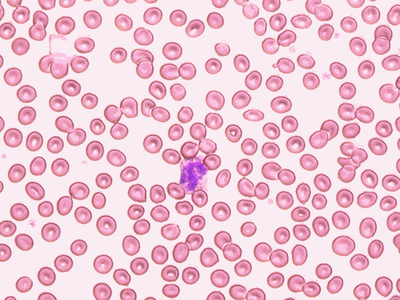

In [2]:
im = Image.open("red_blood_cells.png")
im

In [3]:
im.mode
# RGBA model - RGB + alpha channel

'RGBA'

We have to prepare probability distributions for the pixel if it belongs to the foreground or the background.

In [21]:
foreground = Image.open('foreground.png')
background = Image.open('background.png')

In [130]:
# we consider a 'G' channel which is most useful in distinguishing foreground and background
foreground_data = np.array(foreground.getchannel('G'))
background_data = np.array(background.getchannel('G'))

In [23]:
foreground_data = foreground_data.reshape(foreground_data.shape[0] * foreground_data.shape[1], 1)
background_data = background_data.reshape(background_data.shape[0] * background_data.shape[1], 1)

In [24]:
background_data.shape

(25620, 1)

In [25]:
mu1, std1 = norm.fit(foreground_data)
mu2, std2 = norm.fit(background_data)

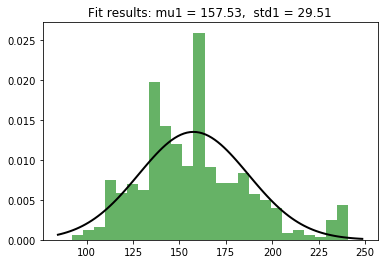

In [26]:
# Plot the histogram for the foreground data
plt.hist(foreground_data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu1, std1)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu1 = %.2f,  std1 = %.2f" % (mu1, std1)
plt.title(title)

plt.show()

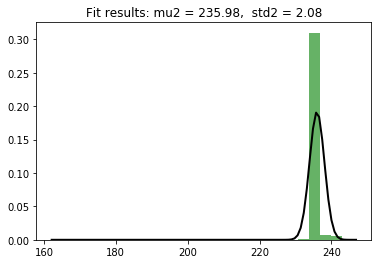

In [27]:
# Plot the histogram for the background data
plt.hist(background_data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu2, std2)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu2 = %.2f,  std2 = %.2f" % (mu2, std2)
plt.title(title)

plt.show()

In [28]:
def get_probability(mu, std, value):
    # given a mu and std describing normal distribution
    # we calculate the probability of 'value'
    # to belong to this dataset
    return norm(mu, std).pdf(value)

In [29]:
print(get_probability(mu2, std2, 232))

0.03073212752406331


In [129]:
# Pipeline do przetwarzania obrazu, powiedzmy dość dużego, z pdziałem na podobrazy...

In [93]:
def get_distributions():
    foreground = Image.open('foreground.png')
    background = Image.open('background.png')
    
    foreground_data = np.array(foreground.getchannel('G'))
    background_data = np.array(background.getchannel('G'))
    
    foreground_data = foreground_data.reshape(foreground_data.shape[0] * foreground_data.shape[1], 1)
    background_data = background_data.reshape(background_data.shape[0] * background_data.shape[1], 1)
    
    mu1, std1 = norm.fit(foreground_data)
    mu2, std2 = norm.fit(background_data)
    
    return mu1, std1, mu2, std2

In [92]:
def create_graph(arr, mu1, std1, mu2, std2):
    G = nx.DiGraph()
    
    # defining vertex set
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            G.add_node((i,j))
    G.add_node('s')
    G.add_node('t')
    
        # definig edges set with proper weigths
    for i1 in range(arr.shape[0]):
        for j1 in range(arr.shape[1]):
            for i2 in range(i1, arr.shape[0]):
                for j2 in range(j1, arr.shape[1]):
                    if (i1 == i2 and j1 == j2 - 1) or (i1 == i2 - 1 and j1 == j2):
                        capacity = np.exp((-0.5 * 1./((std1 + std2)/2.)**2)) * ((arr[i1,j1] - arr[i2,j2])**2)
                        # capacity = 2 * ((arr[i1,j1] - arr[i2,j2]) / 255.)
                        G.add_edge((i1,j1), (i2,j2), capacity=capacity)
                        G.add_edge((i2,j2), (i1,j1), capacity=capacity)

    # wagi dla łuków (s, e) i (e, t)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            cap_s = get_probability(mu1, std1, arr[i, j])
            cap_t = get_probability(mu2, std2, arr[i, j])
            cap_sum = cap_s + cap_t
            G.add_edge('s', (i,j), capacity=2 * cap_s / cap_sum)
            G.add_edge((i,j), 't', capacity=2 * cap_t / cap_sum)
            
    return G

In [96]:
def get_bitmap(R, threshold, dimx, dimy):
    bitmap = np.zeros((dimx, dimy))
    for i in range(dimx):
        for j in range(dimy):
            if R['s'][(i,j)]['flow'] > threshold:
                bitmap[i][j] = 1
    return bitmap

In [113]:
def image_processing_pipeline(image):
    # image to np.array,
    # domyslnie pochodzi z modelu RGB
    width, height, depth = image.shape

    result_image = np.zeros((width, height, depth))
    
    mu1, std1, mu2, std2 = get_distributions()
    
    w_coords = list(range(0, width, 32))
    h_coords = list(range(0, height, 32))
    
    if w_coords[-1] != width - 1:
        w_coords.append(width-1)
    if h_coords[-1] != height - 1:
        h_coords.append(height-1)

    for d in range(depth):
        # dzielimy na bloki po 32x32 pixeli
        for w in range(len(w_coords) - 1): # bez ostatniego elementu
            for h in range(len(h_coords) - 1):
                arr = image[w_coords[w]:w_coords[w+1], h_coords[h]:h_coords[h+1], d]
                
                G = create_graph(arr, mu1, std1, mu2, std2)
                
                R = edmonds_karp(G, 's', 't')
                
                print('Current flow:', R.graph['flow_value'], end=' ')
                
                dimx = w_coords[w+1] - w_coords[w]
                dimy = h_coords[h+1] - h_coords[h]
                bitmap = get_bitmap(R, 0.3, dimx, dimy)
                
                arr2 = arr * bitmap
                
                result_image[w_coords[w]:w_coords[w+1], h_coords[h]:h_coords[h+1], d] = arr2
                
                print('Slice {}:{},{}:{},{} done!'.format(w_coords[w], w_coords[w+1], h_coords[h], h_coords[h+1], d))
                
                # można to puścić wielowątkowo :>
    return result_image

In [111]:
im_arr = im_arr.reshape((300,400,1))
# image_processing_pipeline(im)

In [114]:
result = image_processing_pipeline(im_arr)

/home/pawel/anaconda3/envs/Studies/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in ubyte_scalars


Current flow: 581.8773330950595 Slice 0:32,0:32,0 done!
Current flow: 446.69542573199664 Slice 0:32,32:64,0 done!
Current flow: 465.76440929118684 Slice 0:32,64:96,0 done!
Current flow: 485.5095596285203 Slice 0:32,96:128,0 done!
Current flow: 551.2872108456637 Slice 0:32,128:160,0 done!
Current flow: 406.8843582994262 Slice 0:32,160:192,0 done!
Current flow: 428.3279370123 Slice 0:32,192:224,0 done!
Current flow: 330.0388197712684 Slice 0:32,224:256,0 done!
Current flow: 514.7918512150659 Slice 0:32,256:288,0 done!
Current flow: 494.9946747795223 Slice 0:32,288:320,0 done!
Current flow: 445.0278080871462 Slice 0:32,320:352,0 done!
Current flow: 649.8627182717535 Slice 0:32,352:384,0 done!
Current flow: 234.44004991941102 Slice 0:32,384:399,0 done!
Current flow: 496.40298109493506 Slice 32:64,0:32,0 done!
Current flow: 468.505815056067 Slice 32:64,32:64,0 done!
Current flow: 523.1288804559857 Slice 32:64,64:96,0 done!
Current flow: 232.25762794159948 Slice 32:64,96:128,0 done!
Current 

In [116]:
result.shape

(300, 400, 1)

In [119]:
result = result.reshape((300,400))

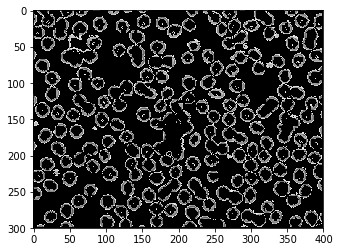

In [121]:
plt.imshow(result, interpolation='nearest', cmap='gray')

In [123]:
# Wniosek - dużo zachodu, a wynik jak po zwykłym filtrowaniu

In [126]:
im2 = im2[:100,:100,:]

In [127]:
im2.shape

(100, 100, 4)

In [128]:
result = image_processing_pipeline(im2)

/home/pawel/anaconda3/envs/Studies/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in ubyte_scalars


Current flow: 424.50739847977616 Slice 0:32,0:32,0 done!
Current flow: 440.8315934785053 Slice 0:32,32:64,0 done!
Current flow: 343.11727123231805 Slice 0:32,64:96,0 done!
Current flow: 53.261738355127356 Slice 0:32,96:99,0 done!
Current flow: 316.97635748080046 Slice 32:64,0:32,0 done!
Current flow: 255.30499914085965 Slice 32:64,32:64,0 done!
Current flow: 339.25724290844465 Slice 32:64,64:96,0 done!
Current flow: 0.0013955360256843591 Slice 32:64,96:99,0 done!
Current flow: 346.4395606605022 Slice 64:96,0:32,0 done!
Current flow: 276.5665997407437 Slice 64:96,32:64,0 done!
Current flow: 345.09306148805075 Slice 64:96,64:96,0 done!
Current flow: 0.0012165806317019027 Slice 64:96,96:99,0 done!
Current flow: 26.49165290765473 Slice 96:99,0:32,0 done!
Current flow: 26.854740958308835 Slice 96:99,32:64,0 done!
Current flow: 39.456917983637446 Slice 96:99,64:96,0 done!
Current flow: 0.0001789982456508596 Slice 96:99,96:99,0 done!
Current flow: 581.8773330950595 Slice 0:32,0:32,1 done!
Cur

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


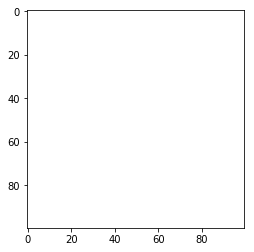

In [142]:
plt.imshow(result, interpolation='nearest')

In [143]:
result

array([[[  0., 147., 176.,   0.],
        [  0., 227.,   0.,   0.],
        [  0.,   0., 244.,   0.],
        ...,
        [  0.,   0., 243.,   0.],
        [  0.,   0., 243.,   0.],
        [  0.,   0.,   0.,   0.]],

       [[  0., 118., 134.,   0.],
        [244., 216., 230.,   0.],
        [  0.,   0., 246.,   0.],
        ...,
        [  0.,   0., 243.,   0.],
        [  0.,   0., 243.,   0.],
        [  0.,   0.,   0.,   0.]],

       [[183., 107.,   0.,   0.],
        [  0., 186., 216.,   0.],
        [  0.,   0., 246.,   0.],
        ...,
        [  0.,   0., 243.,   0.],
        [  0.,   0., 243.,   0.],
        [  0.,   0.,   0.,   0.]],

       ...,

       [[  0.,   0., 243.,   0.],
        [  0.,   0., 243.,   0.],
        [  0.,   0., 243.,   0.],
        ...,
        [  0., 182.,   0.,   0.],
        [  0.,   0., 246.,   0.],
        [  0.,   0.,   0.,   0.]],

       [[  0.,   0., 243.,   0.],
        [  0.,   0., 243.,   0.],
        [  0.,   0., 243.,   0.],
        .